In [1]:
import pandas as pd
import numpy as np
import folium as fl
import requests
import seaborn as sns

import patsy
import statsmodels.api as sm

import import_ipynb

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:

sales = pd.read_csv('selected_bargaining_data.csv')
sales.shape

(556, 55)

In [3]:
cols = sales.columns.values
cols[:10]

array(['event_id', 'action_id', 'round_id', 'buyer_offer_id', 'buyer_id',
       'listing_id', 'property_id', 'agent_id', 'action_price',
       'sales_price'], dtype=object)

In [4]:
#Data cleaning: type casting to datetime
sales['listing_date'] = pd.to_datetime(sales['listing_date'])
sales['off_market_date'] = pd.to_datetime(sales['off_market_date'])


In [5]:
#locate record of price revision
sales['action'].unique()

array(['buyer_offer', 'seller_initialize', 'seller_revise'], dtype=object)

In [6]:
#Feature engineeringn

#computing property age as of year of 2022
sales['home_age'] = 2022- sales['year_built']

#computing listing durtaion
sales['duration_listed_day'] = (sales['off_market_date'] - sales['listing_date']).apply(lambda d:d.days)

#check if the action is a price revision
sales['price_revise'] = sales['action'].str.contains('revise')

In [7]:
sales[sales['home_age'].isna()]['year_built'].isna().all()
#home age missing since year built missing

True

In [8]:
sales['action'].unique()

array(['buyer_offer', 'seller_initialize', 'seller_revise'], dtype=object)

In [9]:
#Task 1: aggreagate by Event (Mean, std, min, max, median)
# property age (using the variable “built_year”) => 'age' 
# number of buyers (identified by unique “buyer_id”)
# number of seller revisions => 'price_revise'
# duration until off market (using variable “off_market_date”, in days) => 'duration_listed_day'
# and sales price (using the variable “de_sales_price”).


In [10]:
sales['duration_listed_day'].describe()

count    556.000000
mean      67.458633
std       82.361366
min       -1.000000
25%        8.000000
50%       40.000000
75%       91.000000
max      405.000000
Name: duration_listed_day, dtype: float64

In [11]:
sub_event = sales[['event_id', 'action_id', 'home_age', 'price_revise', 'buyer_id', 'de_sales_price', 'duration_listed_day']]

#check descriptive stats on action level: screen for anomalies
obj_stats = pd.DataFrame(index = ['count', 'unique', 'top', 'freq'])
float_stats = pd.DataFrame(index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
for c in sub_event.columns:
    ser = sub_event[c]
    if ser.dtype in ('object', 'bool'):
        obj_stats = pd.concat([obj_stats, ser.describe()], axis = 1)
    elif ser.dtype in ('float', 'int'):
        float_stats = pd.concat([float_stats, ser.describe()], axis = 1)

In [12]:
obj_stats

,event_id,price_revise,buyer_id
count,556,556,204
unique,200,2,201
top,c30a23ad11b9a9a63e5f3da13fbe8ad6_2019-02-21,False,b555275c3a31179cda2cf2de0d150532
freq,11,404,2


In [13]:
#abnormal entry: min('duration_listed_day' == -1)
float_stats

,action_id,home_age,de_sales_price,duration_listed_day
count,556.000000,478.000000,4.710000e+02,556.000000
mean,2.244604,42.326360,4.699875e+05,67.458633
std,1.528547,30.562891,2.493851e+05,82.361366
min,1.000000,3.000000,1.043353e+05,-1.000000
25%,1.000000,20.000000,3.034925e+05,8.000000
50%,2.000000,35.000000,4.114225e+05,40.000000
75%,3.000000,57.500000,5.747514e+05,91.000000
max,11.000000,162.000000,1.561797e+06,405.000000


In [14]:
#abnormal entry: fixing abnormal data
abn_duration = sales[sales['duration_listed_day'] == -1]
abn_duration[['listing_date', 'off_market_date']]

,listing_date,off_market_date
453,2013-01-15 23:59:00,2013-01-15
454,2013-01-15 23:59:00,2013-01-15


In [15]:
#same-sale, mannually corrected to 0
sales['duration_listed_day'] = sales['duration_listed_day'].replace(-1, 0)

In [16]:
#aggregate to event level data
event_agg = sales.groupby('event_id').agg({'home_age':'mean', 
                                               'de_sales_price':'first',
                                               'price_revise':'sum',
                                               'duration_listed_day':'first',
                                              'buyer_id':'nunique'})
event_agg.head()

,home_age,de_sales_price,price_revise,duration_listed_day,buyer_id
event_id,,,,,
001370852fffd22950e8d19c12f0988b_2016-04-06,54.0,453631.7188,0,15,1
00b2fd07ffb644247149c0dc546b113b_2012-09-28,81.0,249355.9531,0,81,1
01299f50f55038becc1001c41787419d_2019-10-01,14.0,290668.8750,0,3,1
04da69484c9acd761d8952be43a0060b_2017-11-01,63.0,NaN,0,197,1
053dfd0e9a1bcd20c18f41cb70cdaaf6_2018-08-14,19.0,208668.6406,0,10,1


In [17]:
#descriptive statistics per column
event_agg.agg(['mean', 'std', 'min', 'median', 'max']).round(2)

,home_age,de_sales_price,price_revise,duration_listed_day,buyer_id
mean,45.33,473402.28,0.76,48.47,1.01
std,31.97,243858.41,1.41,66.71,0.10
min,3.00,104335.29,0.00,0.00,1.00
median,36.00,411422.53,0.00,22.50,1.00
max,162.00,1561797.00,9.00,405.00,2.00


In [18]:
#Task 2- geographical plotting of bargining events: (Data cleaning and generting ONLY)

In [19]:
fips_code = pd.read_csv('cbsa2fipsxw.csv')
fips_code.head(3)

,cbsacode,metrodivisioncode,csacode,cbsatitle,metropolitanmicropolitanstatis,metropolitandivisiontitle,csatitle,countycountyequivalent,statename,fipsstatecode,fipscountycode,centraloutlyingcounty
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33860.0,NaN,NaN,"Montgomery, AL",Metropolitan Statistical Area,NaN,NaN,Autauga County,Alabama,1.0,1.0,Central
2,19300.0,NaN,380.0,"Daphne-Fairhope-Foley, AL",Metropolitan Statistical Area,NaN,"Mobile-Daphne-Fairhope, AL",Baldwin County,Alabama,1.0,3.0,Central


In [20]:
state_code = fips_code[['fipsstatecode','statename']]
state_code = state_code.drop_duplicates().reset_index(drop = True)
state_code.columns = ['state_code', 'state_name']
#drop null row for type casting
state_code = state_code[1:]
#cast to zero-filled two digits string: float -> int -> str -> zfill
state_code['state_code'] = state_code['state_code'].apply(int).apply(str).str.zfill(2)

state_code.head(3)

,state_code,state_name
1,01,Alabama
2,02,Alaska
3,04,Arizona


In [21]:
#aggreagate to event-level data: extract state code and county code for plotting
sub_geo = sales[['censustract', 'event_id']]
sub_geo = sub_geo.groupby('event_id').agg('first').reset_index()
#fill upto 11 digits
sub_geo['fips'] = sub_geo['censustract'].apply(str).str.zfill(11)
#first 2 out of 11 as state code, next 3 as county code (stand by)
sub_geo['state_code'], sub_geo['county_code'] = sub_geo['fips'].str[:2], sub_geo['fips'].str[2:5]

#merging to get state name
sub_geo = sub_geo.merge(state_code, on = 'state_code', how = 'left')

#aggregate count by state
state_freq = sub_geo.groupby('state_name')[['event_id']].agg('nunique')
state_freq.columns = ['freq']
state_freq = state_freq.reset_index()
state_freq.head()
#exported for task 2
#state_freq.to_csv('state_freq.csv')

,state_name,freq
0,Arizona,7
1,Arkansas,1
2,California,51
3,Colorado,5
4,District of Columbia,6


In [22]:
#regression analysis
sales.columns

Index(['event_id', 'action_id', 'round_id', 'buyer_offer_id', 'buyer_id',
       'listing_id', 'property_id', 'agent_id', 'action_price', 'sales_price',
       'original_list_price', 'final_listing_price', 'unit_sales_price',
       'de_action_price', 'de_sales_price', 'de_unit_sales_price',
       'de_original_list_price', 'de_final_listing_price', 'actor', 'action',
       'multiple_buyers', 'multiple_buyers_adjusted',
       'number_of_additional_offers', 'number_of_add_offers_adjusted',
       'total_num_buyers_action', 'total_num_buyers_round',
       'total_num_buyers_event', 'deal_status', 'censustract',
       'property_latitude', 'property_longitude', 'property_type',
       'num_bedrooms', 'num_bathrooms', 'approx_sq_ft', 'lot_sq_ft',
       'financing_contingency_waived', 'inspection_contingency_waived',
       'escalation_clause', 'preinspection', 'client_letter', 'year_built',
       'deal_status_notes', 'walk_score', 'transit_score', 'bike_score',
       'prob_offer_sub_d

In [23]:
#selected var for screening
selected = [ 'approx_sq_ft', 
            'lot_sq_ft', 'num_bathrooms', 
            'num_bedrooms', 'event_id', 'total_num_buyers_event']

In [24]:
sub_reg = sales[selected]
sub_reg = sub_reg.groupby('event_id').agg('nunique')
to_concat_reg = []
for c in sub_reg:
    to_concat_reg.append(sub_reg[c].describe())
pd.concat(to_concat_reg, axis =1).loc[['min', 'max']]
#make sure aggregation is correct, such that entries are event-specific

,approx_sq_ft,lot_sq_ft,num_bathrooms,num_bedrooms,total_num_buyers_event
min,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0


In [25]:
#concated with additional variables
selected_agg = sales[selected].groupby('event_id').agg('first')
event_agg = event_agg.merge(selected_agg, left_index = True, right_index = True)

In [26]:
#some more additioanl variables aggregated/appended:
event_agg['de_org_listing_price'] = sales.groupby('event_id')['de_original_list_price'].first()
#transformation price to log(price)
event_agg['log_de_p'] = np.log(event_agg['de_sales_price'])
#transportation rating
event_trans = sales.groupby('event_id')[['walk_score', 'bike_score', 'transit_score']].first()
event_agg = event_agg.merge(event_trans, left_index = True, right_index = True)
event_agg['score_trspt'] = event_agg['walk_score'] + event_agg['bike_score'] + event_agg['transit_score']

#property Type
event_agg['property_type'] = sales.groupby('event_id')['property_type'].first()

In [27]:
#log approx sq ft
event_agg['log_sq_ft'] = np.log(sales.groupby('event_id')['approx_sq_ft'].mean())

In [94]:
#log listing price
event_agg['log_org_listing_p'] = np.log(event_agg['de_org_listing_price'])

In [28]:
#pair map, commented out for time efficiency
#pair = sns.pairplot(event_agg);

In [29]:
#pair.fig.savefig('pair.png')
#saving image

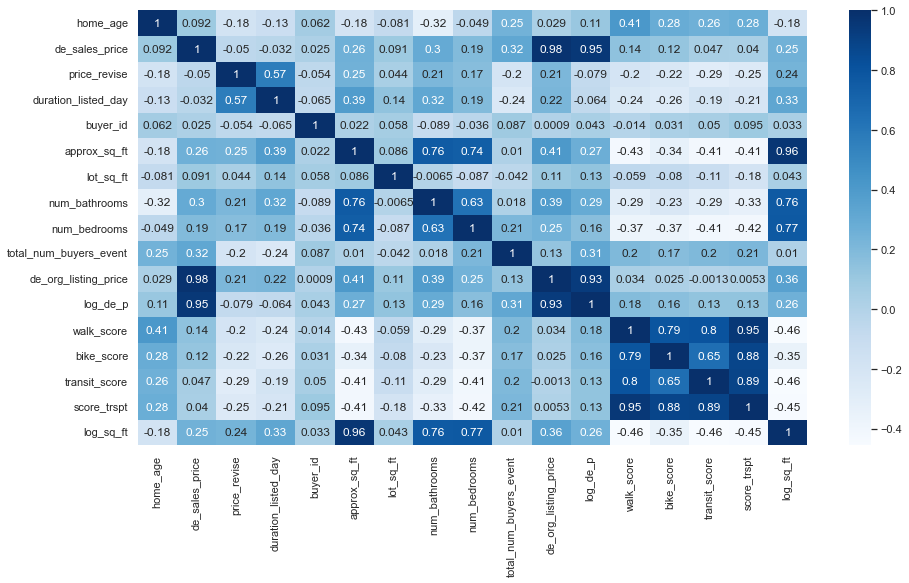

In [30]:
#sns.set(rc = {'figure.figsize':(15,8)})
#sns.heatmap(event_agg.corr(), cbar = True, annot = True, cmap='Blues');

In [31]:
def make_formula(s):
    split = s.split(' ')
    outcome = split[0]
    regressors = split[1:]
    regressors = '+'.join(regressors)
    formula = outcome + ' ~ ' + regressors
    return formula

In [61]:
def get_cols(s):
    cols = s.split(' ')
    if 'de_sales_price' in cols:
        cols.remove('de_sales_price')
    if 'log_de_p' in cols:
        cols.remove('log_de_p')
    return cols

In [32]:
def quickReg(formula, df = event_agg, summary = True):
    #construct the formula
    f = make_formula(formula)
    dep, pred= patsy.dmatrices(f, df)
    mod = sm.OLS(dep, pred)
    #assume heteroskedasticity
    res= mod.fit(cov_type = 'HC3')
    if summary:
        return res.summary()
    else:
        return res

In [33]:
quickReg('de_sales_price de_org_listing_price', summary = False).rsquared

0.9611945129964454

In [34]:
quickReg('de_sales_price de_org_listing_price total_num_buyers_event price_revise duration_listed_day approx_sq_ft')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         de_sales_price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     451.1
Date:                Tue, 24 May 2022   Prob (F-statistic):           3.95e-81
Time:                        21:42:29   Log-Likelihood:                -1634.7
No. Observations:                 138   AIC:                             3281.
Df Residuals:                     132   BIC:                             3299.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.178e+04   1.96e+04      0.603      0.547   -2.65e+04    5.01e+04
de_org_listing_price       1.0086      0.037     27.220      0.000       0.936       1.081
total_num_buyers_event  4782.9207   1604.737      2.981      0.003    1637.694    7928.147
price_revise           -1685.5354   3756.619     -0.449      0.654   -9048.373    5677.302
duration_listed_day     -371.7178    249.851     -1.488      0.137    -861.417     117.981
approx_sq_ft              -7.1148      4.092     -1.739      0.082     -15.135       0.906
==============================================================================
Omnibus:                       61.187   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.821
Skew:                           1.425   Prob(JB):                     4.01e-77
Kurtosis:                      10.285   Cond. No.                     1.58e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='de_sales_price', ylabel='Count'>

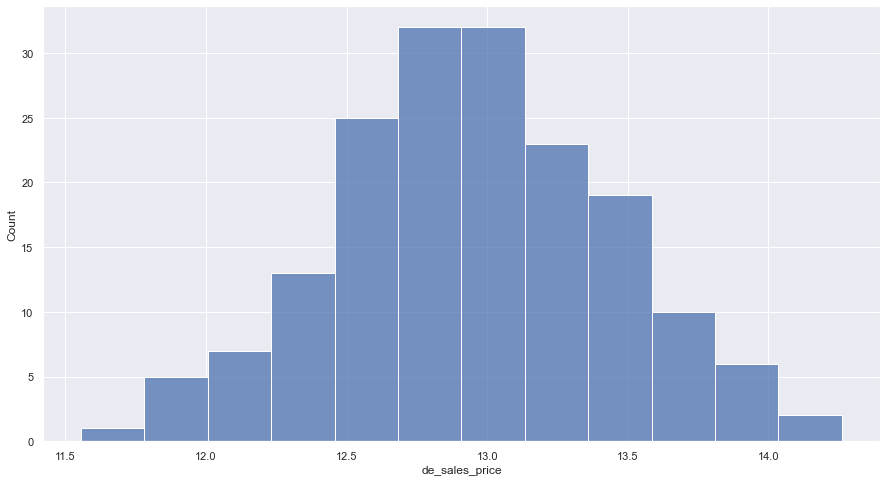

In [36]:
sns.histplot(np.log(event_agg['de_sales_price']))

In [37]:
quickReg('de_sales_price de_org_listing_price total_num_buyers_event price_revise duration_listed_day')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         de_sales_price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     325.7
Date:                Tue, 24 May 2022   Prob (F-statistic):           3.84e-70
Time:                        21:42:29   Log-Likelihood:                -1730.5
No. Observations:                 146   AIC:                             3471.
Df Residuals:                     141   BIC:                             3486.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2284.4918   2.01e+04      0.114      0.909    -3.7e+04    4.16e+04
de_org_listing_price       0.9983      0.035     28.129      0.000       0.929       1.068
total_num_buyers_event  4807.2781   1853.026      2.594      0.009    1175.414    8439.142
price_revise           -2668.9921   3680.057     -0.725      0.468   -9881.772    4543.788
duration_listed_day     -359.1758    233.987     -1.535      0.125    -817.782      99.430
==============================================================================
Omnibus:                       72.692   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.438
Skew:                           1.613   Prob(JB):                    1.17e-107
Kurtosis:                      11.399   Cond. No.                     1.26e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
def iterReg(var, data = event_agg):
    #interpreting formula
    varList = var.split(' ')
    outcome = varList[0]
    regressors = varList[1:]
    
    #total number of remaining unchecked regressors, initialized as len of regressor
    num_reg = len(regressors)
    
    #the currently used formula, initialized as with only (outcome ~)
    curr_fml = str(outcome)
    #holding Result
    order_reg = []
    
    #loop until all var checked
    while len(regressors) > 0:
        #run the regression model with marginal regressor
        
        var_rsq = []
        for reg in regressors:
            temp_fml = curr_fml + ' ' + reg
            temp_rsq = quickReg(temp_fml, summary = False).rsquared
            var_rsq.append(tuple([reg, temp_rsq]))
        #sort variables according to marginal rsq (descending)
        var_rsq = sorted(var_rsq, key = lambda t:t[1], reverse = True)
        #select the var which contributes highest marginal rsq
        var_keep = var_rsq[0][0]
        #record the corresponding r-squared
        rsq_keep = var_rsq[0][1]
        
        #update the optimized formula
        curr_fml = curr_fml + ' ' + var_keep
        
        #remove from candidate list
        regressors.remove(var_keep)
        order_reg.append(tuple([var_keep, rsq_keep]))
    
    #get the order-optimized regression formula
    opt_fml = outcome + ' ' + ' '.join([i[0] for i in order_reg])
    return order_reg, opt_fml

In [39]:
iterReg('de_sales_price home_age price_revise buyer_id approx_sq_ft lot_sq_ft num_bathrooms num_bedrooms')

([('num_bathrooms', 0.08709572734095383),
  ('home_age', 0.11830720618905988),
  ('approx_sq_ft', 0.14675958414921209),
  ('price_revise', 0.174702534310345),
  ('lot_sq_ft', 0.21160125929477802),
  ('buyer_id', 0.2119399377048956),
  ('num_bedrooms', 0.2120220755048029)],
 'de_sales_price num_bathrooms home_age approx_sq_ft price_revise lot_sq_ft buyer_id num_bedrooms')

In [40]:
reg2 = iterReg('log_de_p home_age price_revise buyer_id log_sq_ft num_bathrooms num_bedrooms score_trspt property_type')
reg2

([('num_bathrooms', 0.08675874760178703),
  ('score_trspt', 0.19376637218986748),
  ('log_sq_ft', 0.2619443596496799),
  ('home_age', 0.29888935143429785),
  ('price_revise', 0.3275437739606364),
  ('property_type', 0.353401682288329),
  ('num_bedrooms', 0.3558564597972309),
  ('buyer_id', 0.3591198439417521)],
 'log_de_p num_bathrooms score_trspt log_sq_ft home_age price_revise property_type num_bedrooms buyer_id')

In [55]:
feature_reg = feature_reg = quickReg("log_de_p num_bathrooms score_trspt log_sq_ft home_age price_revise property_type",
                      summary = False)
feature_reg

In [75]:
quickReg("log_de_p num_bathrooms score_trspt log_sq_ft home_age price_revise property_type")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_de_p   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     4.221
Date:                Tue, 24 May 2022   Prob (F-statistic):           0.000317
Time:                        22:01:47   Log-Likelihood:                -45.391
No. Observations:                  85   AIC:                             108.8
Df Residuals:                      76   BIC:                             130.8
Df Model:                           8                                         
Covariance Type:                  HC3                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      7.5570      1.648      4.586      0.000       4.327      10.786
property_type[T.Multi-Family (2-4 Unit)]      -0.4851      1.219     -0.398      0.691      -2.874       1.904
property_type[T.Single Family Residential]    -0.0752      0.183     -0.411      0.681      -0.434       0.284
property_type[T.Townhouse]                     0.2221      0.212      1.050      0.294      -0.193       0.637
num_bathrooms                                  0.0600      0.115      0.522      0.602      -0.166       0.286
score_trspt                                    0.0025      0.001      2.370      0.018       0.000       0.005
log_sq_ft                                      0.6505      0.250      2.597      0.009       0.160       1.141
home_age                                       0.0031      0.002      1.542      0.123      -0.001       0.007
price_revise                                  -0.0635      0.041     -1.543      0.123      -0.144       0.017
==============================================================================
Omnibus:                        0.909   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.982
Skew:                           0.154   Prob(JB):                        0.612
Kurtosis:                       2.574   Cond. No.                     4.78e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
iterReg('de_sales_price home_age de_org_listing_price buyer_id duration_listed_day')

([('de_org_listing_price', 0.9611945129964454),
  ('duration_listed_day', 0.9724218665535004),
  ('home_age', 0.9766286150991288),
  ('buyer_id', 0.9766910542057275)],
 'de_sales_price de_org_listing_price duration_listed_day home_age buyer_id')

In [52]:
market_reg = quickReg('de_sales_price de_org_listing_price duration_listed_day home_age buyer_id', summary = False)
market_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         de_sales_price   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     334.8
Date:                Tue, 24 May 2022   Prob (F-statistic):           9.50e-73
Time:                        21:46:23   Log-Likelihood:                -1813.9
No. Observations:                 152   AIC:                             3638.
Df Residuals:                     147   BIC:                             3653.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.952e+04    3.8e+04     -0.513      0.608    -9.4e+04     5.5e+04
de_org_listing_price     1.0315      0.036     28.357      0.000       0.960       1.103
duration_listed_day   -406.6182    138.869     -2.928      0.003    -678.796    -134.440
home_age               159.0381    108.689      1.463      0.143     -53.989     372.066
buyer_id              1.679e+04   3.38e+04      0.497      0.619   -4.94e+04     8.3e+04
==============================================================================
Omnibus:                       35.803   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.335
Skew:                           0.653   Prob(JB):                     4.67e-42
Kurtosis:                       8.324   Cond. No.                     6.47e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 6.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
feature_reg.fittedvalues

array([13.06762799, 12.96092244, 12.71688842, 12.5597994 , 13.26932444,
       12.8033552 , 13.07323619, 13.21156331, 12.90563862, 12.94140936,
       12.80662931, 12.84460816, 12.6584941 , 12.65317632, 12.67496262,
       13.04674581, 12.54901184, 13.02576414, 13.07575018, 12.88077443,
       13.22530332, 13.42199143, 12.64866521, 13.16255347, 12.88473285,
       13.19931045, 13.34902589, 13.03441098, 13.49479156, 12.69005244,
       13.49058789, 13.11048076, 12.75548521, 12.8846473 , 12.84830766,
       13.01384924, 12.63991327, 12.48632295, 12.91639106, 12.79521897,
       13.00773675, 12.77370285, 13.43501563, 13.28459585, 13.21894898,
       12.89345047, 12.57548066, 12.66159542, 13.03918484, 12.99722433,
       13.7660532 , 12.58145591, 12.9282863 , 13.85756306, 12.1884711 ,
       13.00616608, 12.77202128, 13.3461449 , 13.04818293, 13.14880247,
       13.04681089, 12.79930592, 13.08392659, 13.07394834, 12.52487028,
       13.18091487, 12.92000502, 13.12413139, 13.06870431, 12.47

In [76]:
sales.columns

Index(['event_id', 'action_id', 'round_id', 'buyer_offer_id', 'buyer_id',
       'listing_id', 'property_id', 'agent_id', 'action_price', 'sales_price',
       'original_list_price', 'final_listing_price', 'unit_sales_price',
       'de_action_price', 'de_sales_price', 'de_unit_sales_price',
       'de_original_list_price', 'de_final_listing_price', 'actor', 'action',
       'multiple_buyers', 'multiple_buyers_adjusted',
       'number_of_additional_offers', 'number_of_add_offers_adjusted',
       'total_num_buyers_action', 'total_num_buyers_round',
       'total_num_buyers_event', 'deal_status', 'censustract',
       'property_latitude', 'property_longitude', 'property_type',
       'num_bedrooms', 'num_bathrooms', 'approx_sq_ft', 'lot_sq_ft',
       'financing_contingency_waived', 'inspection_contingency_waived',
       'escalation_clause', 'preinspection', 'client_letter', 'year_built',
       'deal_status_notes', 'walk_score', 'transit_score', 'bike_score',
       'prob_offer_sub_d

In [95]:
pfis = "property_type home_age approx_sq_ft log_sq_ft num_bathrooms num_bedrooms score_trspt"

In [171]:
mris = "duration_listed_day buyer_id total_num_buyers_event log_org_listing_p price_revise"

In [105]:
pfis_vars = iterReg('log_de_p ' + pfis)
pfis_vars

([('num_bathrooms', 0.08675874760178703),
  ('score_trspt', 0.19376637218986748),
  ('log_sq_ft', 0.2619443596496799),
  ('home_age', 0.29888935143429785),
  ('property_type', 0.3196798356805294),
  ('approx_sq_ft', 0.3320284978300839),
  ('num_bedrooms', 0.33456414002354207)],
 'log_de_p num_bathrooms score_trspt log_sq_ft home_age property_type approx_sq_ft num_bedrooms')

In [173]:
mris_vars = iterReg('log_de_p ' + mris)
mris_vars

([('log_org_listing_p', 0.9791594350892481),
  ('total_num_buyers_event', 0.9874151768518526),
  ('duration_listed_day', 0.9913872934504362),
  ('price_revise', 0.9918816199933047),
  ('buyer_id', 0.991916163117203)],
 'log_de_p log_org_listing_p total_num_buyers_event duration_listed_day price_revise buyer_id')

In [182]:
mixed = "property_type home_age log_sq_ft num_bathrooms num_bedrooms score_trspt duration_listed_day buyer_id total_num_buyers_event"

In [183]:
mixed_vars = iterReg('log_de_p ' + mixed)
mixed_vars

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1908: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = (self.wresid / (1 - h))**2


([('total_num_buyers_event', 0.09865834327096712),
  ('num_bathrooms', 0.16101234943102238),
  ('score_trspt', 0.2546123562319309),
  ('log_sq_ft', 0.3049546526133198),
  ('home_age', 0.3522628128251021),
  ('property_type', 0.41254942874729195),
  ('num_bedrooms', 0.4405989824989366),
  ('buyer_id', 0.4472220666826394),
  ('duration_listed_day', 0.44732514149528757)],
 'log_de_p total_num_buyers_event num_bathrooms score_trspt log_sq_ft home_age property_type num_bedrooms buyer_id duration_listed_day')

In [160]:
def plot_iterReg(var_list, low = 0, high = 1):
    values = {}
    values = {'var':[], 'index':[], 'R-sq':[]}
    for i in range(len(var_list)):
        values['var'].append(var_list[i][0])
        values['R-sq'].append(var_list[i][1])
        values['index'].append(i+1)
    df = pd.DataFrame(values)
    f = df.plot(kind = 'line', x = 'index', y = 'R-sq')
    f.set_xticks(df['index'])
    f.set_xticklabels(df['var'], rotation = 35)
    f.set_xlabel('')
    f.set_ylim(low,high)
    return f

In [156]:
sns.set(font_scale = 1.2)

In [166]:
sns.set(rc = {'figure.figsize':(12,4)})

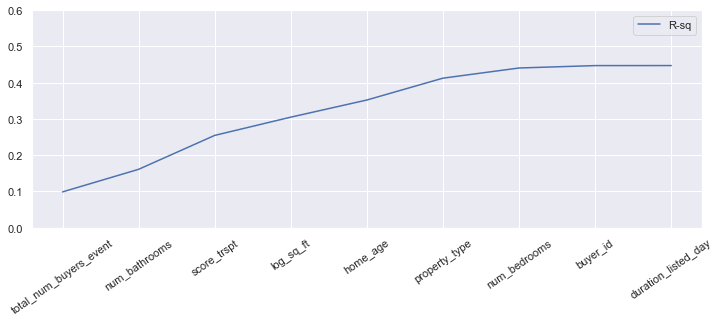

In [185]:
plot_iterReg(mixed_vars[0], high = 0.6);

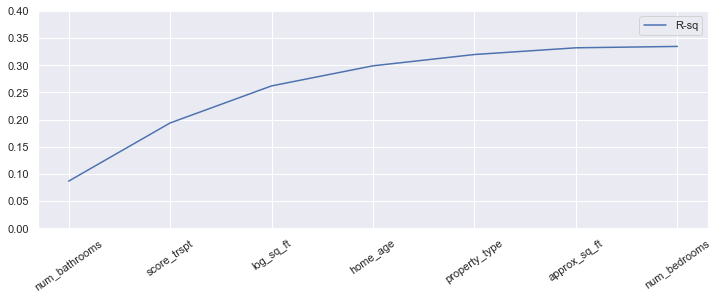

In [168]:
plot_iterReg(pfis_vars[0], high = 0.4);

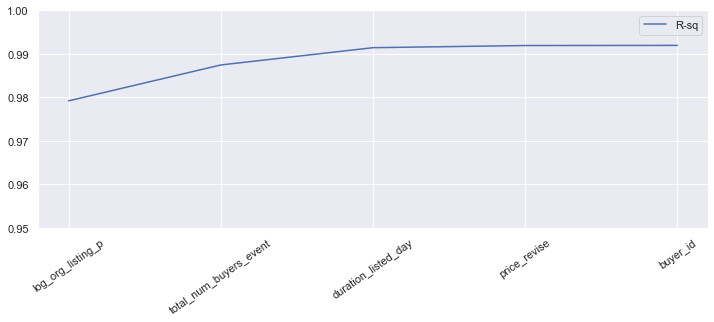

In [174]:
plot_iterReg(mris_vars[0],low = 0.95);

In [177]:
quickReg('log_de_p log_org_listing_p duration_listed_day total_num_buyers_event')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_de_p   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     5398.
Date:                Wed, 25 May 2022   Prob (F-statistic):          4.54e-146
Time:                        01:38:53   Log-Likelihood:                 245.66
No. Observations:                 146   AIC:                            -483.3
Df Residuals:                     142   BIC:                            -471.4
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2178      0.117     -1.860      0.063      -0.447       0.012
log_org_listing_p          1.0162      0.009    107.231      0.000       0.998       1.035
duration_listed_day       -0.0006   6.27e-05     -9.275      0.000      -0.001      -0.000
total_num_buyers_event     0.0077      0.003      2.575      0.010       0.002       0.014
==============================================================================
Omnibus:                       35.093   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.019
Skew:                           0.950   Prob(JB):                     2.84e-20
Kurtosis:                       6.344   Cond. No.                     1.91e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [178]:
quickReg('log_de_p num_bathrooms log_sq_ft home_age score_trspt property_type')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_de_p   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     4.968
Date:                Wed, 25 May 2022   Prob (F-statistic):           0.000113
Time:                        01:54:54   Log-Likelihood:                -47.551
No. Observations:                  85   AIC:                             111.1
Df Residuals:                      77   BIC:                             130.6
Df Model:                           7                                         
Covariance Type:                  HC3                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      7.8114      1.640      4.762      0.000       4.596      11.026
property_type[T.Multi-Family (2-4 Unit)]      -0.4791      1.278     -0.375      0.708      -2.984       2.026
property_type[T.Single Family Residential]    -0.1029      0.185     -0.558      0.577      -0.465       0.259
property_type[T.Townhouse]                     0.1671      0.187      0.892      0.372      -0.200       0.534
num_bathrooms                                  0.0689      0.106      0.649      0.516      -0.139       0.277
log_sq_ft                                      0.6061      0.248      2.440      0.015       0.119       1.093
home_age                                       0.0036      0.002      1.929      0.054   -5.79e-05       0.007
score_trspt                                    0.0025      0.001      2.504      0.012       0.001       0.005
==============================================================================
Omnibus:                        0.394   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.417
Skew:                           0.156   Prob(JB):                        0.812
Kurtosis:                       2.856   Cond. No.                     4.76e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [179]:
mixed

'property_type home_age approx_sq_ft log_sq_ft num_bathrooms num_bedrooms score_trspt duration_listed_day buyer_id total_num_buyers_event'

In [184]:
quickReg('log_de_p '+mixed)



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_de_p   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     3.320
Date:                Wed, 25 May 2022   Prob (F-statistic):            0.00127
Time:                        02:30:11   Log-Likelihood:                -32.811
No. Observations:                  73   AIC:                             89.62
Df Residuals:                      61   BIC:                             117.1
Df Model:                          11                                         
Covariance Type:                  HC3                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      8.3574      4.638      1.802      0.072      -0.732      17.447
property_type[T.Multi-Family (2-4 Unit)]      -2.9087      1.664     -1.748      0.081      -6.171       0.353
property_type[T.Single Family Residential]    -0.2122      0.207     -1.027      0.305      -0.617       0.193
property_type[T.Townhouse]                     0.0285      0.224      0.127      0.899      -0.411       0.468
home_age                                       0.0026      0.002      1.182      0.237      -0.002       0.007
log_sq_ft                                      0.4237      0.383      1.107      0.268      -0.326       1.174
num_bathrooms                                  0.0038      0.124      0.031      0.975      -0.238       0.246
num_bedrooms                                   0.1829      0.135      1.352      0.176      -0.082       0.448
score_trspt                                    0.0024      0.001      1.983      0.047    2.75e-05       0.005
duration_listed_day                            0.0001      0.003      0.042      0.966      -0.005       0.005
buyer_id                                       0.3805      4.115      0.092      0.926      -7.686       8.447
total_num_buyers_event                         0.0456      0.029      1.557      0.119      -0.012       0.103
==============================================================================
Omnibus:                        0.969   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.616   Jarque-Bera (JB):                0.665
Skew:                          -0.232   Prob(JB):                        0.717
Kurtosis:                       3.051   Cond. No.                     5.01e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 5.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

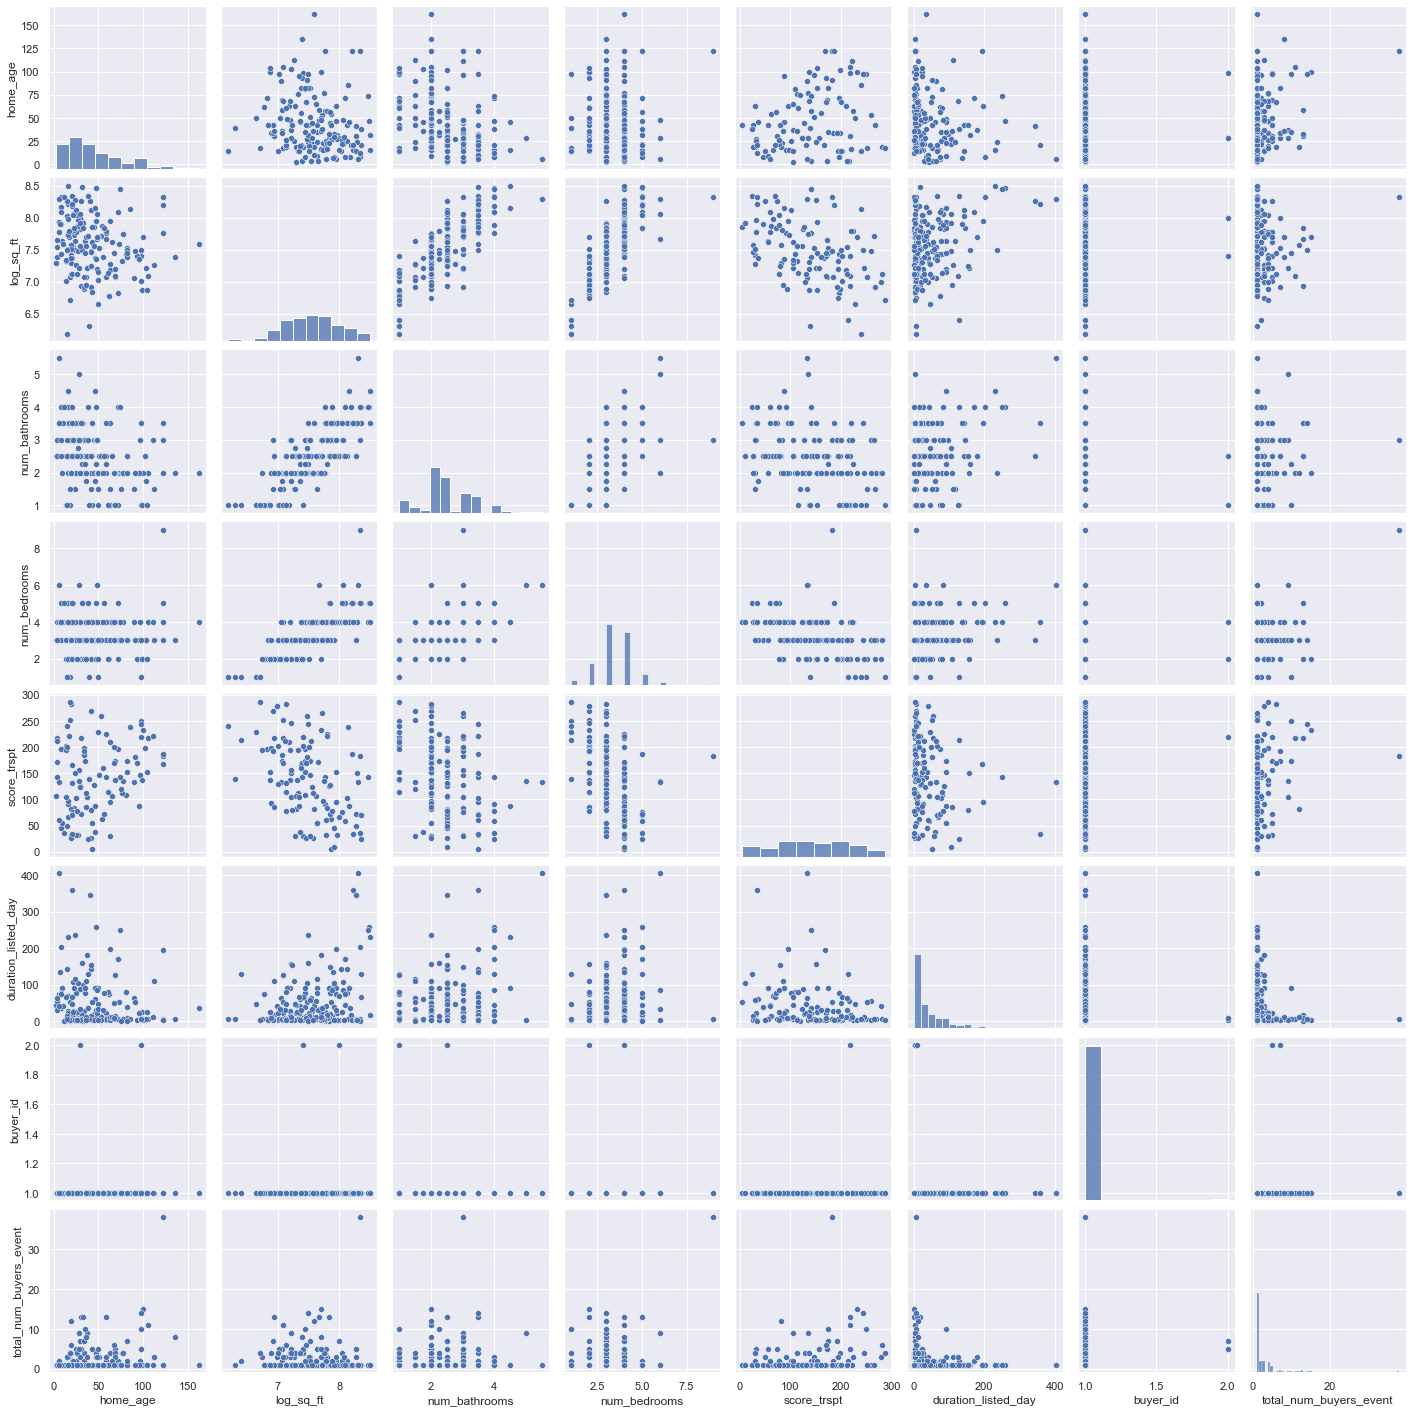

In [188]:
sns.pairplot(event_agg[get_cols('log_de_p '+mixed)]).savefig('pair.png')

<AxesSubplot:>

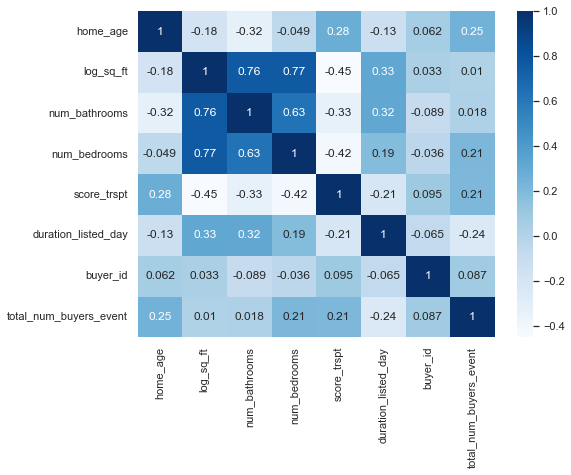

In [192]:
sns.set(rc = {'figure.figsize':(8,6)})
sns.heatmap(event_agg[get_cols('log_de_p '+mixed)].corr(), cbar = True, annot = True, cmap='Blues')